In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
pwrData = pd.read_excel('FullModelData_2020-Mar2022.xlsx')
pwrData = pwrData[['Date', 'Hour_Ending', 'Forecast_Alberta_Internal_Load', 'Risk_Band', 'WIND', 'SOLAR', 'SOLAR2', 'Risk_Category' ]]

In [4]:
# Splitting the Date apart
pwrData['Date'] = pwrData['Date'].astype(str)
date = pwrData['Date'].str.split('-', expand=True)

pwrData = pwrData.drop('Date', axis=1).copy()
    
# Renaming columns  for Date and power usage
mapping={date.columns[0]: 'Year', date.columns[1]: 'Month', date.columns[2]: 'Day'}
date = date.rename(columns=mapping)
          
# Putting everything back together
pwrData = pd.concat([date, pwrData], axis=1)

pwrData['Year'] = pwrData['Year'].astype(int)
pwrData['Month'] = pwrData['Month'].astype(int)
pwrData['Day'] = pwrData['Day'].astype(int)
pwrData.head(48)

,Year,Month,Day,Hour_Ending,Forecast_Alberta_Internal_Load,Risk_Band,WIND,SOLAR,SOLAR2,Risk_Category
0,2020,1,1,10,9867,Medium Risk,396.0,0,1.0,1
1,2020,1,1,11,9973,Medium Risk,396.0,0,2.0,1
2,2020,1,1,12,10060,Medium Risk,365.0,0,3.0,1
3,2020,1,1,13,10094,Medium Risk,287.0,0,3.0,1
4,2020,1,1,14,10079,Medium Risk,223.0,0,5.0,1
5,2020,1,1,15,10064,Medium Risk,131.0,0,2.0,1
6,2020,1,1,16,10145,Medium Risk,129.0,0,1.0,1
7,2020,1,1,17,10460,Medium Risk,174.0,0,0.0,1
8,2020,1,1,18,10840,Medium Risk,219.0,0,0.0,1
9,2020,1,1,19,10741,Medium Risk,301.0,0,0.0,1


In [5]:
pwrData = pwrData[['Year','Month', 'Day', 'Hour_Ending', 'Forecast_Alberta_Internal_Load', 'SOLAR2' , 'WIND',  'Risk_Category']]
mapping={pwrData.columns[5]: 'Solar', pwrData.columns[6]: 'Wind'}
pwrData = pwrData.rename(columns=mapping)
pwrData

,Year,Month,Day,Hour_Ending,Forecast_Alberta_Internal_Load,Solar,Wind,Risk_Category
0,2020,1,1,10,9867,1.0,396.0,1
1,2020,1,1,11,9973,2.0,396.0,1
2,2020,1,1,12,10060,3.0,365.0,1
3,2020,1,1,13,10094,3.0,287.0,1
4,2020,1,1,14,10079,5.0,223.0,1
...,...,...,...,...,...,...,...,...
19432,2022,3,21,5,9149,0.0,1506.0,1
19433,2022,3,21,6,9299,0.0,1471.0,1
19434,2022,3,21,7,9753,0.0,1407.0,1
19435,2022,3,21,8,10142,2.0,1339.0,1


In [6]:
X = pwrData.drop('Risk_Category', axis=1).copy()
X.head()

,Year,Month,Day,Hour_Ending,Forecast_Alberta_Internal_Load,Solar,Wind
0,2020,1,1,10,9867,1.0,396.0
1,2020,1,1,11,9973,2.0,396.0
2,2020,1,1,12,10060,3.0,365.0
3,2020,1,1,13,10094,3.0,287.0
4,2020,1,1,14,10079,5.0,223.0


In [7]:
y = pwrData['Risk_Category'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Risk_Category, dtype: int64

In [7]:
X.dtypes

Year                                int32
Month                               int32
Day                                 int32
Hour_Ending                         int64
Forecast_Alberta_Internal_Load      int64
WIND                              float64
SOLAR2                            float64
dtype: object

In [71]:
forecast.dtypes

Year                                int64
Month                               int64
Day                                 int64
Hour (Ending)                       int64
Forecast_Alberta_Internal_Load      int64
Solar                             float64
Wind                              float64
dtype: object

In [8]:
categories = [0,1,2]

In [9]:
leafs = xgb.DMatrix(forecast, enable_categorical=True)

NameError: name 'forecast' is not defined

In [8]:
y.dtype

dtype('int64')

In [10]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.25)

In [11]:
train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
test = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [12]:
param ={
    'max_depth' : 6,
    'eta' : 0.3,
    'objective' : 'multi:softmax',
    'eval_metric': 'merror',
    'num_class' : 3}
epochs = 10

In [13]:
model = xgb.train(param, train, epochs)

In [15]:
predictions = model.predict(test)

In [16]:
print(predictions)

[2. 0. 0. ... 0. 0. 1.]


In [15]:
from sklearn.metrics import accuracy_score

#TESTING ACCURACY
accuracy_score(y_test,predictions)

0.8331275720164609

In [82]:
flyers= pd.DataFrame(predictions)

In [84]:
something = pd.concat([forecast, flyers], axis=1)
something

,Year,Month,Day,Hour_Ending,Forecast_Alberta_Internal_Load,Solar,Wind,0
0,2022,4,8,6,9280,1.53,1580.24,1.0
1,2022,4,8,7,9577,1.21,1464.59,1.0
2,2022,4,8,8,9887,1.69,1520.41,1.0
3,2022,4,8,9,10078,27.75,1411.50,1.0
4,2022,4,8,10,10033,63.92,1398.05,1.0
5,2022,4,8,11,10032,99.29,1238.98,1.0
6,2022,4,8,12,10079,141.47,1309.36,1.0
7,2022,4,8,13,10104,245.27,1528.97,1.0
8,2022,4,8,14,10077,258.49,1929.81,1.0
9,2022,4,8,15,10065,244.95,1988.48,1.0


4860

In [31]:
import pickle

In [49]:
filename = 'Solve4X_model.model'
pickle.dump(model, open(filename, 'wb'))

In [76]:
import csv
forecast = pd.read_csv('APR8 Predictions.csv')
mapping={forecast.columns[3]: 'Hour_Ending'}
forecast = forecast.rename(columns=mapping)
forecast

,Year,Month,Day,Hour_Ending,Forecast_Alberta_Internal_Load,Solar,Wind
0,2022,4,8,6,9280,1.53,1580.24
1,2022,4,8,7,9577,1.21,1464.59
2,2022,4,8,8,9887,1.69,1520.41
3,2022,4,8,9,10078,27.75,1411.50
4,2022,4,8,10,10033,63.92,1398.05
5,2022,4,8,11,10032,99.29,1238.98
6,2022,4,8,12,10079,141.47,1309.36
7,2022,4,8,13,10104,245.27,1528.97
8,2022,4,8,14,10077,258.49,1929.81
9,2022,4,8,15,10065,244.95,1988.48


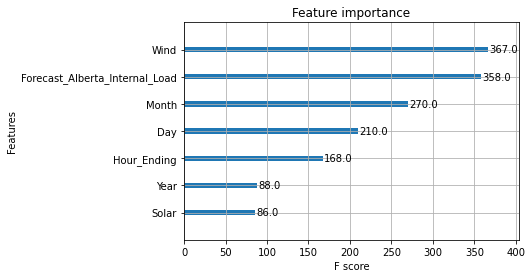

In [43]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

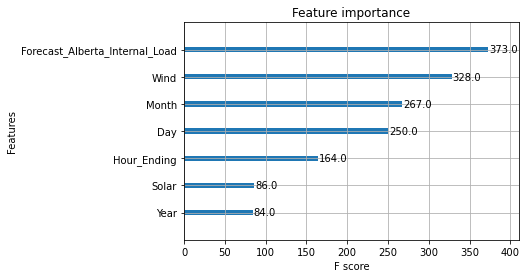

In [17]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()